# Eigenvalue spectra and noise

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import jax.numpy as np
import numpy as onp
import time
from tqdm import tqdm
from led_array.bsccm_utils import *
from plot_utils import *
from image_utils import extract_patches, compute_eigenvalues
from matplotlib.colors import LinearSegmentedColormap

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')
bsccm_coherent = BSCCM('/home/hpinkard_waller/data/BSCCM-coherent/')

Opening BSCCM
Opened BSCCM
Opening BSCCM-coherent
Opened BSCCM-coherent


# plot the eigenvalue spectra of coherent illumination

100%|██████████| 20000/20000 [00:00<00:00, 441101.73it/s]


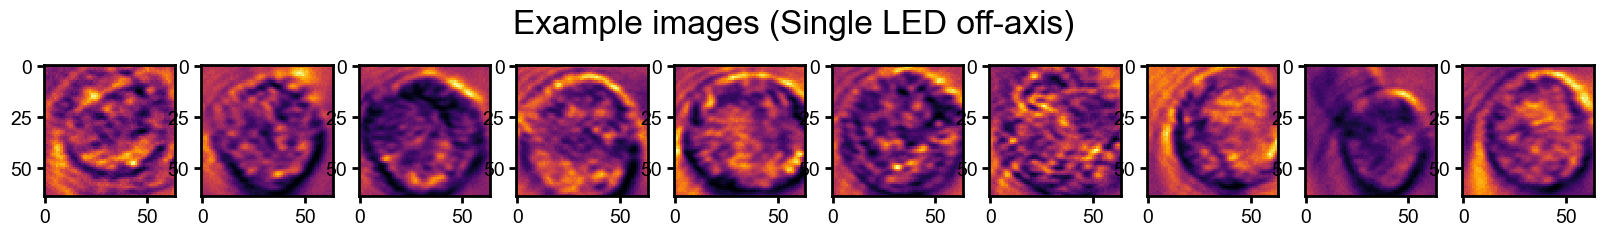

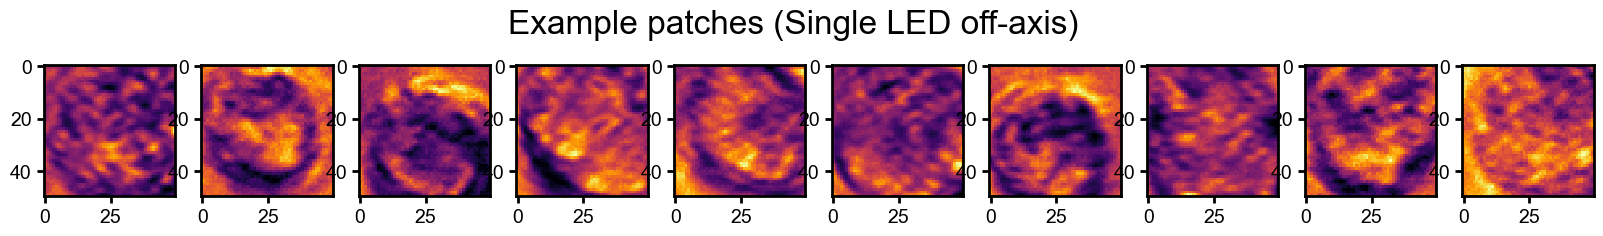

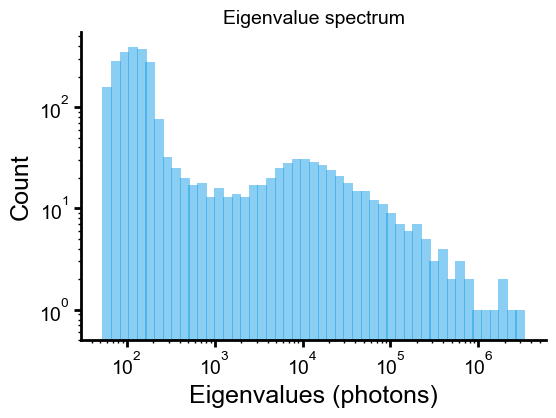

In [33]:
num_images = 1000
patch_size = 50
num_patches = 20000

images = load_bsccm_images(bsccm, 'LED119', num_images=num_images, edge_crop=32, convert_units_to_photons=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)
values = compute_eigenvalues(patches)

# plot a few example images
fig, axes = plt.subplots(1, 10, figsize=(20, 2.5))
for j in range(10):
    axes[j].imshow(images[j], cmap='inferno', interpolation='nearest')
    # axes[j].axis('off')
display_name = get_display_channel_names('LED119')
fig.suptitle(f'Example images ({display_name})')
fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_example_images' + '.pdf', transparent=True)


# plot a few example patches
fig, axes = plt.subplots(1, 10, figsize=(20, 2.5))
for j in range(10):
    axes[j].imshow(patches[j], cmap='inferno', interpolation='nearest')
    # axes[j].axis('off')
fig.suptitle(f'Example patches ({display_name})')
fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_example_patches' + '.pdf', transparent=True)

# plot the eigenvalue spectrum
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
h = OverlayedHistograms(ax=ax)
h.add(values)
h.plot()
ax.set(xlabel='Eigenvalues (photons)', ylabel='Count', title='Eigenvalue spectrum')
clear_spines(ax)
fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_eigenvalue_spectrum' + '.pdf', transparent=True)

# Visualize number of photons in image and SNR

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 977.39it/s]


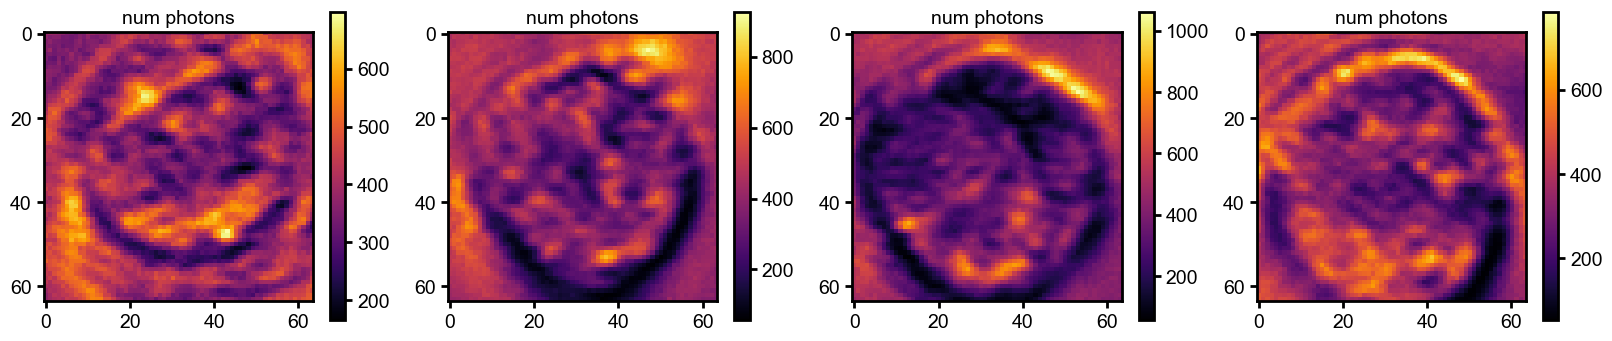

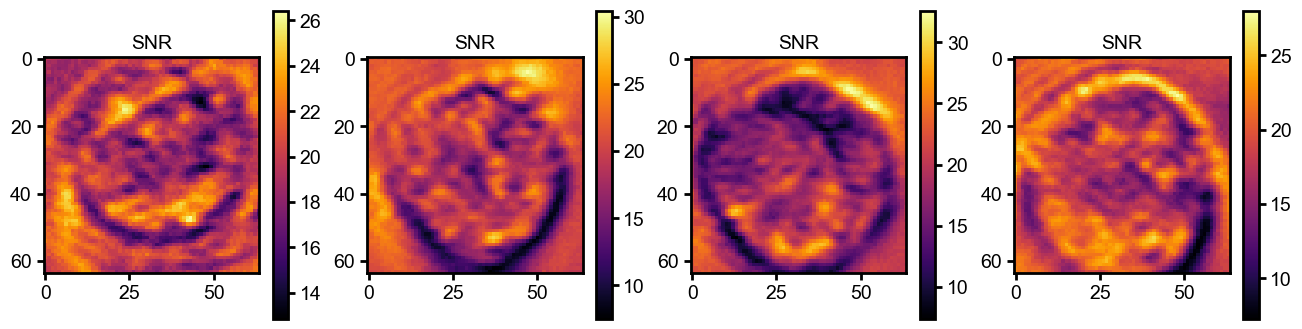

In [36]:

images = load_bsccm_images(bsccm, 'LED119', num_images=num_images, edge_crop=32, convert_units_to_photons=True)

num_to_plot = 4
# plot a few example images
fig, axes = plt.subplots(1, num_to_plot, figsize=(20, 4))
for j in range(num_to_plot):
    axes[j].imshow(images[j], cmap='inferno', interpolation='nearest')
    axes[j].set(title='num photons')
    fig.colorbar(axes[j].imshow(images[j], cmap='inferno', interpolation='nearest'), ax=axes[j])

fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_images_with_photon_scalebar' + '.pdf', transparent=True)

# plot snr of images
fig, axes = plt.subplots(1, num_to_plot, figsize=(16, 4))
for j in range(num_to_plot):
    snr = images[j] / np.sqrt(images[j])
    axes[j].imshow(snr, cmap='inferno', interpolation='nearest')
    axes[j].set(title='SNR')
    fig.colorbar(axes[j].imshow(snr, cmap='inferno', interpolation='nearest'), ax=axes[j])

fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_images_with_snr_scalebar' + '.pdf', transparent=True)

# Observe changes in EV spectrum with additive Gaussian noise

100%|██████████| 20000/20000 [00:00<00:00, 431937.14it/s]


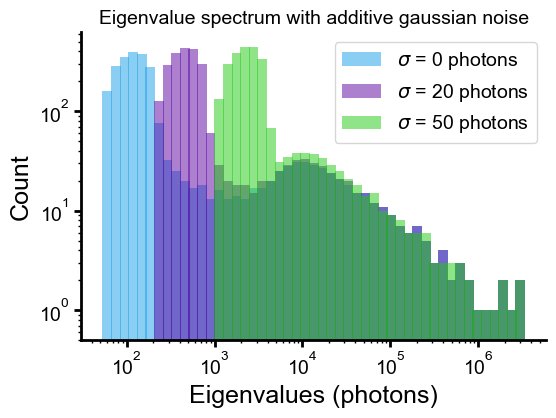

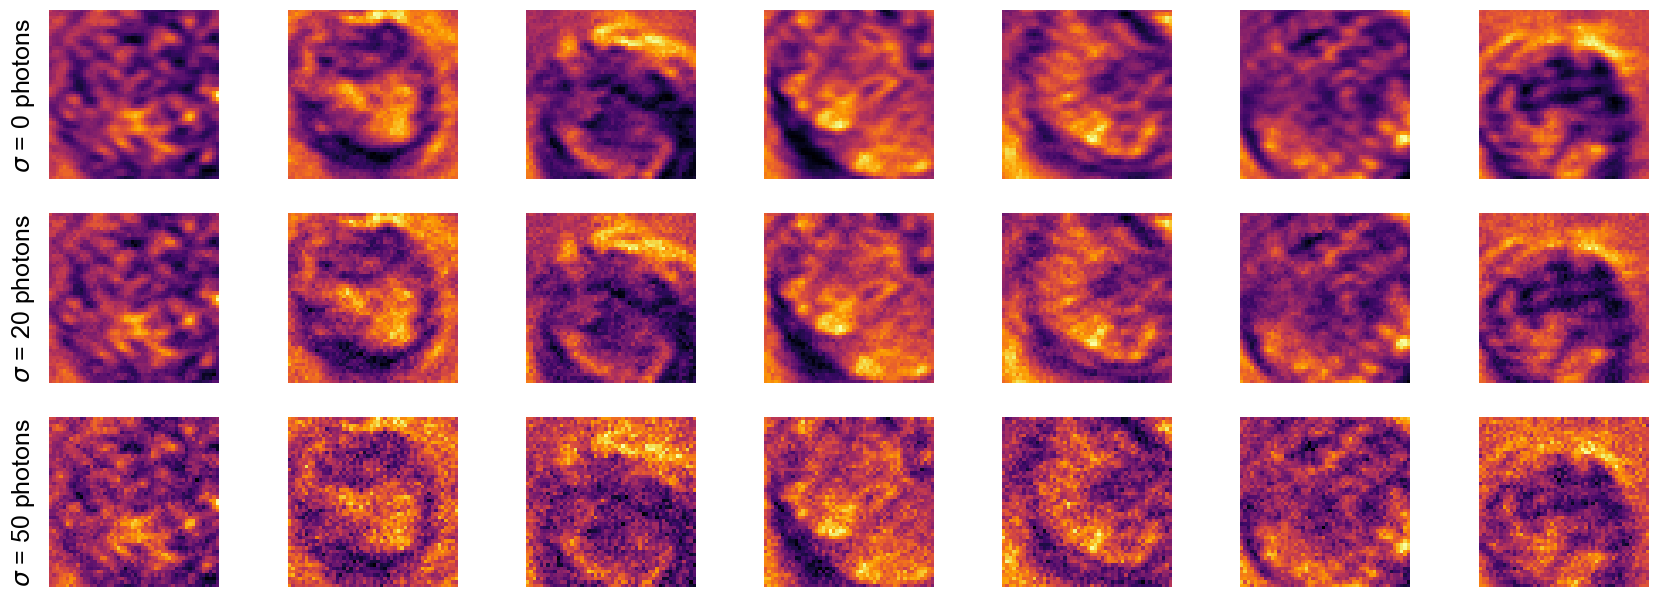

In [38]:
# See how adding noise changes the eigenvalue spectrum
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

images = load_bsccm_images(bsccm, 'LED119', num_images=num_images, edge_crop=32, convert_units_to_photons=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

noise_levels = [0, 20, 50]
num_patches_to_show = 7

example_patch_fig, example_patch_axes = plt.subplots(len(noise_levels), 
                                        num_patches_to_show, figsize=(3 * num_patches_to_show, len(noise_levels) * 2.5))
hist = OverlayedHistograms(ax=axes)
for index, noise_level in enumerate(noise_levels):

    noisy_patches = patches + noise_level * onp.random.randn(*patches.shape)

    for j in range(num_patches_to_show):
        im = example_patch_axes[index, j].imshow(noisy_patches[j], cmap='inferno', interpolation='nearest')
        clear_spines(example_patch_axes[index, j], all=True)
        example_patch_axes[index, j].set(xticks=[], yticks=[])
    example_patch_axes[index, 0].set_ylabel('$\sigma$ = {} photons'.format(noise_level))

    values = compute_eigenvalues(noisy_patches)
    if values.min() == 0:
        print('removing {} zero eigenvalues'.format(np.sum(values == 0)))
        values = values[values > 0]
    hist.add(values, label='$\sigma$ = {} photons'.format(noise_level))
    
hist.plot()
axes.set(xlabel='Eigenvalues (photons)', ylabel='Count', title='Eigenvalue spectrum with additive gaussian noise')
axes.legend()
clear_spines(axes)
fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_eigenvalue_spectrum_with_additive_gaussiannoise' + '.pdf', transparent=True)

example_patch_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_example_patches_with_additive_gaussian_noise' + '.pdf', transparent=True)


# Observe changes with additve poisson noise
Add poisson noise corresponding to the actual amount number of photons, and as if fewer had been collected

100%|██████████| 20000/20000 [00:00<00:00, 446718.18it/s]


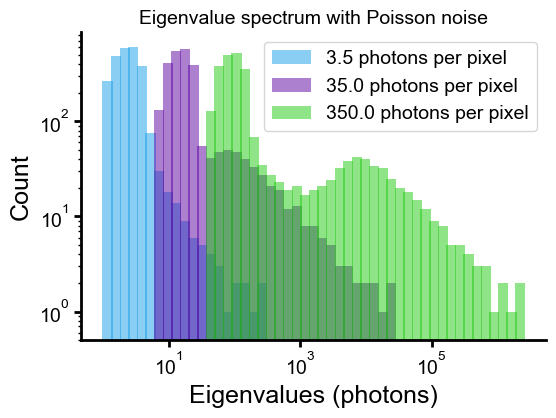

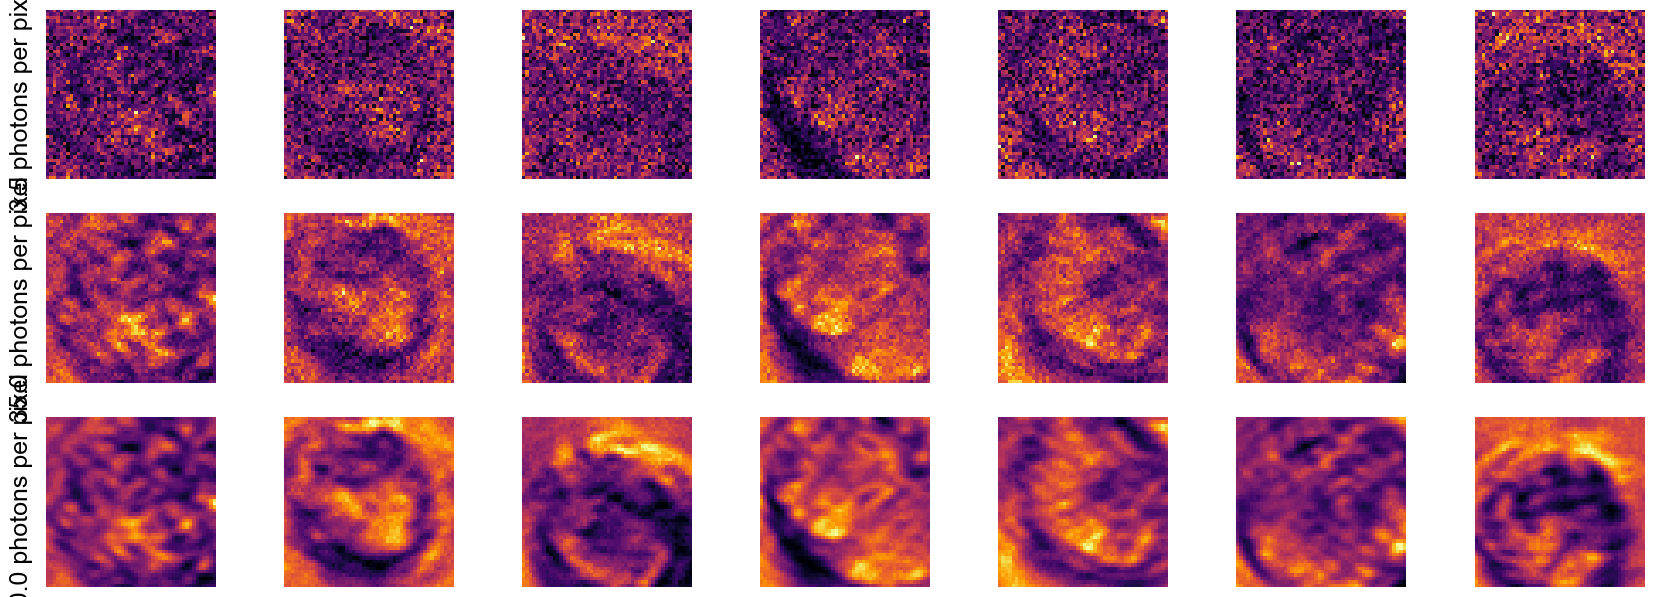

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(6,4))

example_patch_fig, example_patch_axes = plt.subplots(len(noise_levels), 
                                        num_patches_to_show, figsize=(3 * num_patches_to_show, len(noise_levels) * 2.5))

photon_counts = [3.5, 35, 350]

images = load_bsccm_images(bsccm, 'LED119', num_images=num_images, edge_crop=32, convert_units_to_photons=True)
photon_scaled_patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)
average_photons_per_pixel = np.mean(photon_scaled_patches)

hist = OverlayedHistograms(ax=axes)
for index, photon_fraction in enumerate([photon_count / average_photons_per_pixel for photon_count in photon_counts]):
    noisy_patches = add_shot_noise_to_experimenal_data(photon_scaled_patches, photon_fraction=photon_fraction)
  
    for j in range(num_patches_to_show):
        im = example_patch_axes[index, j].imshow(noisy_patches[j], cmap='inferno', interpolation='nearest')
        clear_spines(example_patch_axes[index, j], all=True)
        example_patch_axes[index, j].set(xticks=[], yticks=[])
    example_patch_axes[index, 0].set_ylabel('{} photons per pixel'.format(photon_fraction * average_photons_per_pixel))

    values = compute_eigenvalues(noisy_patches)
    if values.min() == 0:
        print('removing {} zero eigenvalues'.format(np.sum(values == 0)))
        values = values[values > 0]
        
    hist.add(values, label='{} photons per pixel'.format(photon_fraction * average_photons_per_pixel))

hist.plot()
axes.set(xlabel='Eigenvalues (photons)', ylabel='Count', title='Eigenvalue spectrum with Poisson noise')
axes.legend()
clear_spines(axes)
fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_eigenvalue_spectrum_with_equalized_poisson_noise' + '.pdf', transparent=True)

example_patch_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_example_patches_with_equalized_poisson_noise' + '.pdf', transparent=True)

# Eigenvalue spectra of real data with different exposures of LED 119

100%|██████████| 20000/20000 [00:00<00:00, 376606.48it/s]


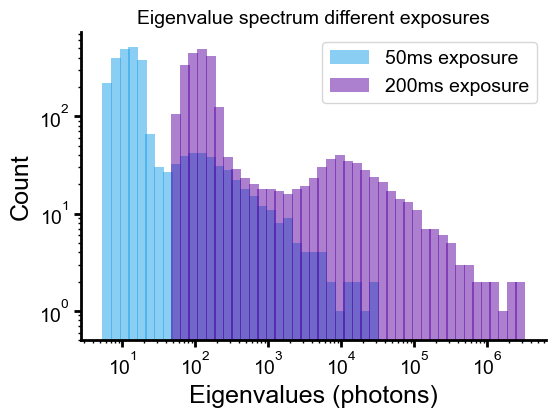

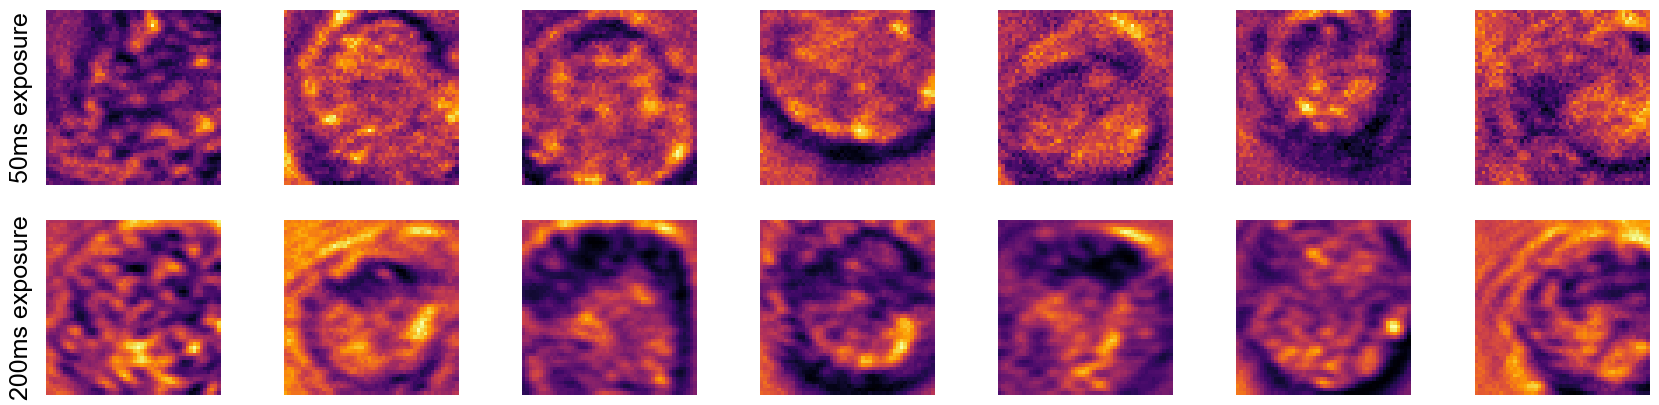

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(6,4))

example_patch_fig, example_patch_axes = plt.subplots(2, 
                                        num_patches_to_show, figsize=(3 * num_patches_to_show, 2 * 2.5))

hist = OverlayedHistograms(ax=axes)
for index, (dataset, channel_name) in enumerate(zip([bsccm_coherent, bsccm], ['led_119', 'LED119'])):
    exposure = dataset.global_metadata['led_array']['exposure_ms'][channel_name]

    images = load_bsccm_images(dataset, channel_name, num_images=4000, edge_crop=32, convert_units_to_photons=True)
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

    # plot a few example patches
    for j in range(num_patches_to_show):
        im = example_patch_axes[index, j].imshow(patches[j], cmap='inferno', interpolation='nearest')
        clear_spines(example_patch_axes[index, j], all=True)
        example_patch_axes[index, j].set(xticks=[], yticks=[])
    example_patch_axes[index, 0].set_ylabel('{}ms exposure'.format(exposure))

    values = compute_eigenvalues(patches)
    hist.add(values, label='{}ms exposure'.format(exposure))
    axes.set(xlabel='Eigenvalues (photons)', ylabel='Count', title='Eigenvalue spectrum')

hist.plot()
axes.set(xlabel='Eigenvalues (photons)', ylabel='Count', title='Eigenvalue spectrum different exposures')
axes.legend()
clear_spines(axes)
fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_eigenvalue_spectrum_real_data_with_different_exposure' + '.pdf', transparent=True)

example_patch_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_example_patches_real_data_with_different_exposure' + '.pdf', transparent=True)

# Is there a normalization that allows better comparison of poisson noise?

100%|█████████████████████████████████████████| 20000/20000 [00:30<00:00, 645.69it/s]


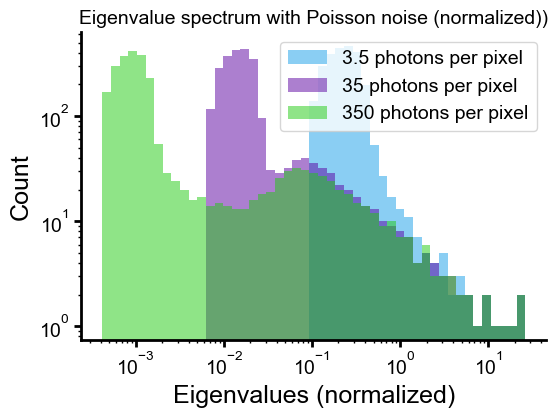

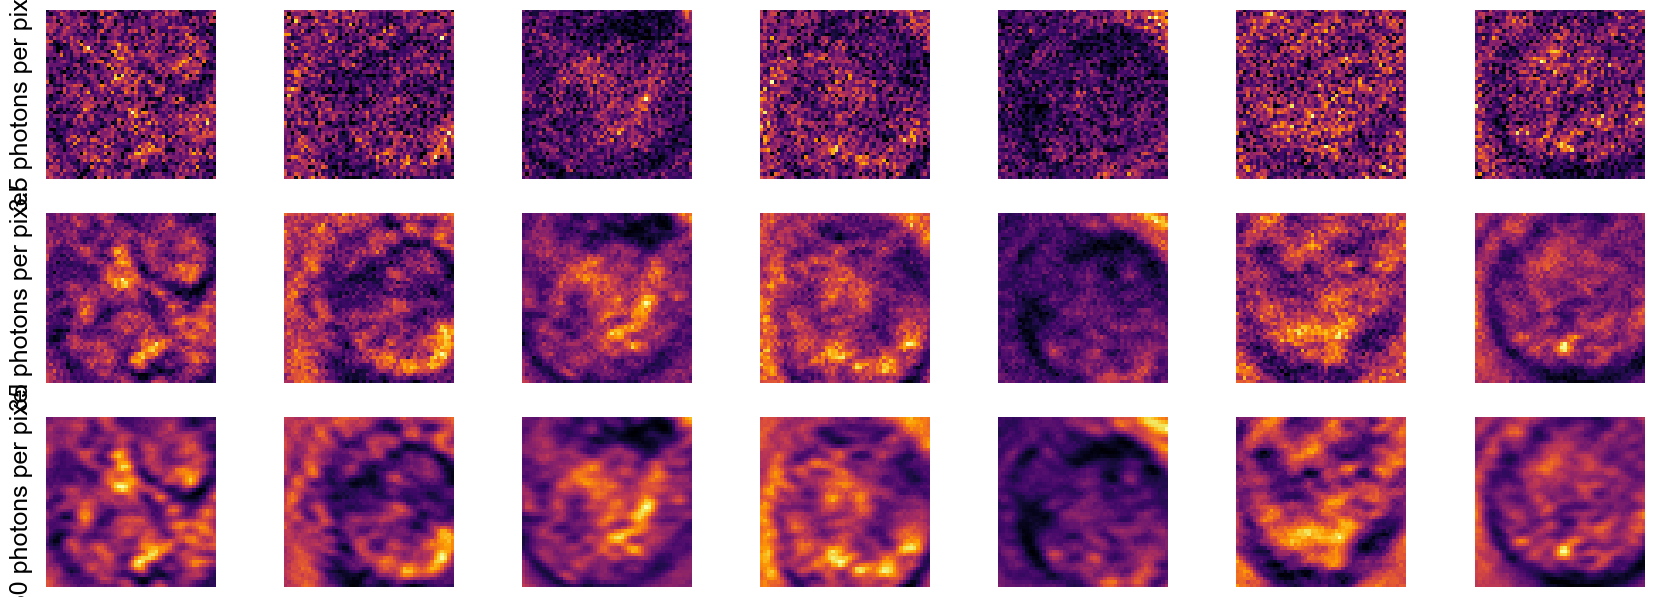

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(6,4))

example_patch_fig, example_patch_axes = plt.subplots(len(noise_levels), 
                                        num_patches_to_show, figsize=(3 * num_patches_to_show, len(noise_levels) * 2.5))

photon_counts = [3.5, 35, 350]

images = load_bsccm_images(bsccm, 'LED119', num_images=num_images, edge_crop=32, convert_units_to_photons=True)
photon_scaled_patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

hist = OverlayedHistograms(ax=axes)
for index, photons_per_pixel in enumerate(photon_counts):
    noisy_patches = add_shot_noise_to_experimenal_data(photon_scaled_patches, photons_per_pixel=photons_per_pixel)
    # do normalization -- should this be diving by N or sqrt(N)?
    noisy_patches /= np.sqrt(photons_per_pixel)

    for j in range(num_patches_to_show):
        im = example_patch_axes[index, j].imshow(noisy_patches[j], cmap='inferno', interpolation='nearest')
        clear_spines(example_patch_axes[index, j], all=True)
        example_patch_axes[index, j].set(xticks=[], yticks=[])
    example_patch_axes[index, 0].set_ylabel('{} photons per pixel'.format(photons_per_pixel))

    values = compute_eigenvalues(noisy_patches)
    if values.min() == 0:
        print('removing {} zero eigenvalues'.format(np.sum(values == 0)))
        values = values[values > 0]
        
    hist.add(values, label='{} photons per pixel'.format(photons_per_pixel))

hist.plot()
axes.set(xlabel='Eigenvalues (normalized)', ylabel='Count', title='Eigenvalue spectrum with Poisson noise (normalized))')
axes.legend()
clear_spines(axes)
fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_eigenvalue_spectrum_with_equalized_poisson_noise' + '.pdf', transparent=True)

example_patch_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_example_patches_with_equalized_poisson_noise_normalized' + '.pdf', transparent=True)

# What do noise only eigenvalues look like?
Commenting out for now because this experiment needs more thought

100%|█████████████████████████████████████████| 20000/20000 [00:28<00:00, 695.46it/s]


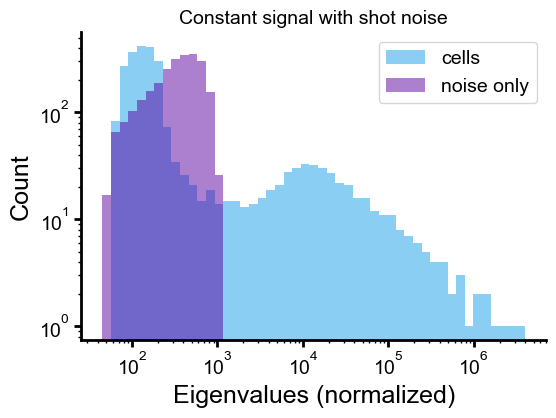

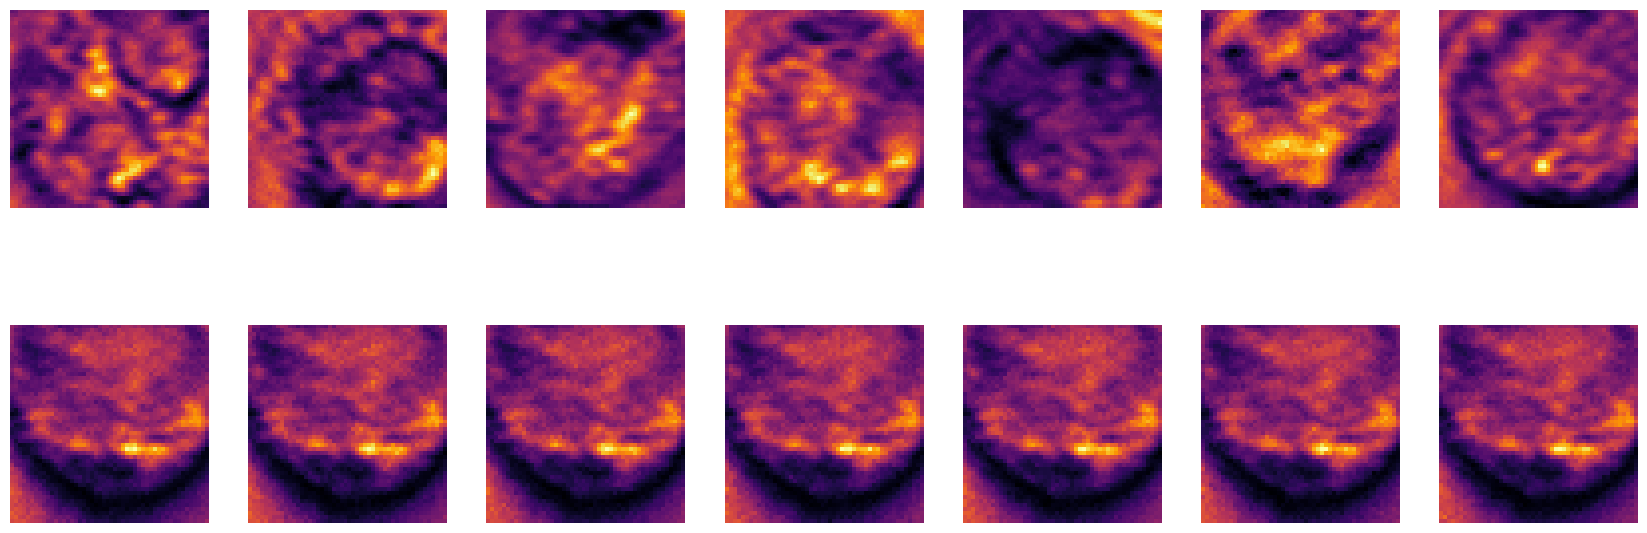

In [8]:
# fig, axes = plt.subplots(1, 1, figsize=(6,4))

# example_patch_fig, example_patch_axes = plt.subplots(2, 
#                                         num_patches_to_show, figsize=(3 * num_patches_to_show, len(noise_levels) * 2.5))
# photon_scaled_stack = load_bsccm_images(bsccm, 'LED119', num_images=num_images, edge_crop=32, convert_units_to_photons=True)
# photon_scaled_patches = extract_patches(photon_scaled_stack, patch_size=patch_size, num_patches=num_patches)

# hist = OverlayedHistograms(ax=axes)

# for index, label in enumerate(['cells', 'noise only']):
#     if label == 'noise only':
#         # pick a random patch and set all patches to that value, so that all eigenvalues come from noise
#         photon_scaled_patches = np.ones_like(photon_scaled_patches) * photon_scaled_patches[9]

#     noisy_patches = simulate_shot_noise(photon_scaled_patches, assume_noiseless=label == 'noise only')

#     for j in range(num_patches_to_show):
#         im = example_patch_axes[index, j].imshow(noisy_patches[j], cmap='inferno', interpolation='nearest')
#         clear_spines(example_patch_axes[index, j], all=True)
#         example_patch_axes[index, j].set(xticks=[], yticks=[])

#     values = compute_eigenvalues(noisy_patches)
#     if values.min() == 0:
#         print('removing {} zero eigenvalues'.format(np.sum(values == 0)))
#         values = values[values > 0]
        
#     hist.add(values, label=label)

# hist.plot()
# axes.set(xlabel='Eigenvalues (normalized)', ylabel='Count', title='Constant signal with shot noise')
# axes.legend()
# clear_spines(axes)
# # fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_eigenvalue_spectrum_with_equalized_poisson_noise' + '.pdf', transparent=True)

# # example_patch_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'intro_example_patches_with_equalized_poisson_noise_normalized' + '.pdf', transparent=True)